In [1]:
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
import datetime
#this is to allow you to see the plot in the notebook
%matplotlib inline 
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [2]:
CONFIG = configparser.ConfigParser()
CONFIG.read(r'/home/jchew/local/db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

## This is a notebook explaining how we determine the set of gap sizes to be used for future Miovision process. 

**Note that all data below are taken from `miovision_api.volumes` with datetime_bin BETWEEN '2020-05-01 00:00:00' AND '2020-06-30 23:59:00'** 

Steps:
1) Find all gaps > 1 minutes in order to determine the common gap sizes at different time period of the day (namely midnight, AM and PM) 

2) Testing out suggested volume-gap (Option A) and find out the percentage of data within suggested gap based on different volume range ( [0,99), [100,499), [500,1499), [1500,∞) )

3) From the results of Option A, find the point/gap size where `cumu_pct_desc`(cumulative percentage in descending order) is about 0.02. That means that for each volume category, we are only removing about 0.02% of the data (hopefully) which leads us to the set of volume-gap Option B.

4) Looking at the results from Option A (being more strict) and B (being more conservative), trying out a new set of volume-gap which is sth between A and B and has a more uniformly distributed set of allowed gap size which leads us to Option C.

5) Combining all results from Options A, B and C and put them side by side for easier comparison and analyse them using a few metrics

## 1) Finding all gaps

Trying out with 3 different time range: 12am - 6am (MIDNIGHT) , 6am - 3pm (AM) , 3pm - 12 am (PM) 

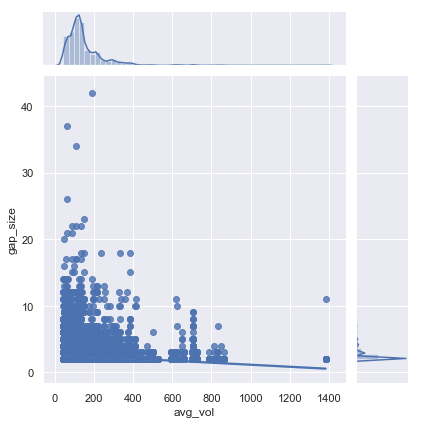

In [4]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE time_bin BETWEEN '00:00:00'::time AND '06:00:00'::time 
    AND gap_size < 50 
    AND gap_size > 0
    ''')
    # removing 1 outlier here
    data_3am_1min = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', kind='reg', data=data_3am_1min)

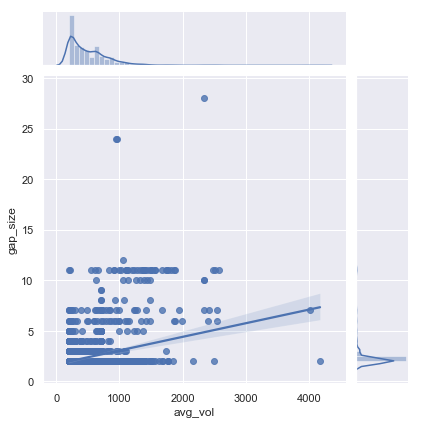

In [5]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE time_bin BETWEEN '06:00:00'::time AND '15:00:00'::time 
    AND gap_size < 50
    AND gap_size > 0
    ''')
    # removing 2 outliers here
    data_3am_1min = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', kind='reg', data=data_3am_1min)

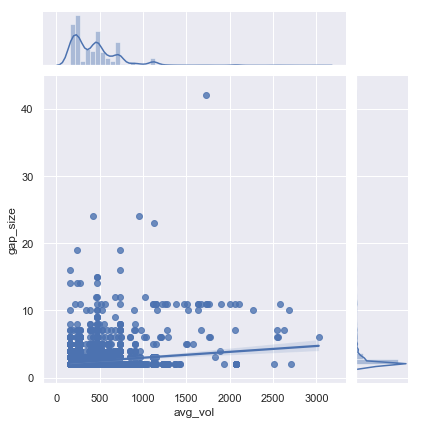

In [6]:
with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE time_bin BETWEEN '15:00:00'::time AND '23:00:00'::time 
    AND gap_size < 100
    AND gap_size > 0
    ''')
    # removing 2 outliers here
    data_5pm_1min = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', kind='reg', data=data_5pm_1min)

# 2) Testing out suggested volume-gap

# **Option A**

Based on the plots, suggesting the following gaps: \
volume [0,99): 20 mins \
volume [100,499): 10 mins \
volume [500,1499): 5 mins \
volume [1500,∞): 2 mins \
Plotting them according to volume (instead of time) to investigate further.

## For volume between 0 and 99

*Note: Plot (outlier removed) followed by table (outlier not removed)*

    gap_size     pct  cumu_pct_desc
0        0.0   2.003         97.997
1        2.0  58.884         39.113
2        3.0  21.845         17.268
3        4.0   9.167          8.101
4        5.0   3.933          4.168
5        6.0   1.920          2.248
6        7.0   0.996          1.252
7        8.0   0.537          0.715
8        9.0   0.276          0.439
9       10.0   0.164          0.275
10      11.0   0.082          0.193
11      12.0   0.077          0.116
12      13.0   0.015          0.101
13      14.0   0.029          0.072
14      15.0   0.010          0.062
15      16.0   0.010          0.052
16      17.0   0.010          0.042
17      20.0   0.005          0.037
18      21.0   0.010          0.027
19      22.0   0.005          0.022
20      26.0   0.005          0.017
21      37.0   0.005          0.012
22      60.0   0.005          0.007
23      64.0   0.005          0.002
24     387.0   0.005         -0.003


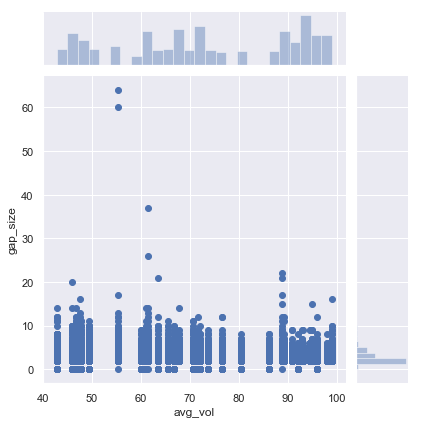

In [3]:
with con:   
    sql = pg.SQL('''
    WITH sel AS (
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE avg_vol < 100
        )
    , percentage AS (
    SELECT gap_size, COUNT(*),
    ROUND(count(*)::numeric / 20673 * 100, 3) AS pct
    FROM sel
    GROUP BY gap_size
    ORDER BY gap_size
    )
    SELECT gap_size, pct,
    100 - ( sum(pct) over (order by gap_size asc rows between unbounded preceding and current row)) AS cumu_pct_desc
    FROM percentage
    ''')
    data_pct = pandasql.read_sql(sql, con)
    
print(data_pct)

with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE avg_vol < 100
    AND gap_size < 100
    ''')
    # removing 1 outlier here
    data_100 = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', data=data_100) #, kind="kde"

## For volume between 100 and 499

    gap_size     pct  cumu_pct_desc
0        0.0   7.350         92.650
1        2.0  74.911         17.739
2        3.0  12.806          4.933
3        4.0   3.047          1.886
4        5.0   0.944          0.942
5        6.0   0.398          0.544
6        7.0   0.206          0.338
7        8.0   0.071          0.267
8        9.0   0.071          0.196
9       10.0   0.042          0.154
10      11.0   0.047          0.107
11      12.0   0.038          0.069
12      13.0   0.013          0.056
13      14.0   0.013          0.043
14      15.0   0.007          0.036
15      16.0   0.002          0.034
16      17.0   0.005          0.029
17      18.0   0.009          0.020
18      19.0   0.002          0.018
19      22.0   0.004          0.014
20      23.0   0.002          0.012
21      24.0   0.002          0.010
22      34.0   0.002          0.008
23      42.0   0.002          0.006
24      50.0   0.002          0.004
25     216.0   0.002          0.002
26     667.0   0.002        

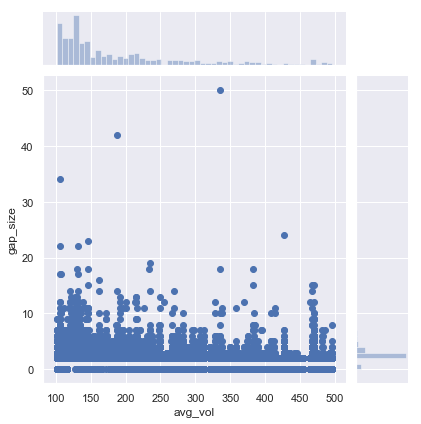

In [4]:
with con:   
    sql = pg.SQL('''
    WITH sel AS (
        SELECT intersection_uid, time_bin, avg_vol, gap_size 
        FROM miovision_api.volume_gap_1min
        WHERE avg_vol < 500
        AND avg_vol >= 100
        )
    , percentage AS (
    SELECT gap_size, COUNT(*),
    ROUND(count(*)::numeric / 54773 * 100, 3) AS pct
    FROM sel
    GROUP BY gap_size
    ORDER BY gap_size
    )
    SELECT gap_size, pct,
    100 - ( sum(pct) over (order by gap_size asc rows between unbounded preceding and current row)) AS cumu_pct_desc
    FROM percentage
    ''')
    data_pct = pandasql.read_sql(sql, con)
    
print(data_pct)

with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE avg_vol < 500
    AND avg_vol >= 100
    AND gap_size < 200
    ''')
# removing 2 outliers here
data_500 = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', data=data_500)

## For volume between 500 and 1499

    gap_size     pct  cumu_pct_desc
0        0.0  85.372         14.628
1        2.0  12.331          2.297
2        3.0   1.245          1.052
3        4.0   0.274          0.778
4        5.0   0.188          0.590
5        6.0   0.150          0.440
6        7.0   0.128          0.312
7        8.0   0.047          0.265
8        9.0   0.013          0.252
9       10.0   0.047          0.205
10      11.0   0.158          0.047
11      12.0   0.017          0.030
12      16.0   0.004          0.026
13      19.0   0.004          0.022
14      23.0   0.004          0.018
15      24.0   0.009          0.009
16     159.0   0.004          0.005
17     189.0   0.004          0.001


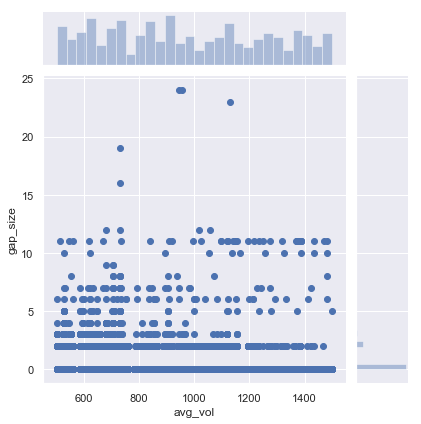

In [5]:
with con:   
    sql = pg.SQL('''
    WITH sel AS (
        SELECT intersection_uid, time_bin, avg_vol, gap_size 
        FROM miovision_api.volume_gap_1min
        WHERE avg_vol < 1500
        AND avg_vol >= 500
        )
    , percentage AS (
    SELECT gap_size, COUNT(*),
    ROUND(count(*)::numeric / 23380 * 100, 3) AS pct
    FROM sel
    GROUP BY gap_size
    ORDER BY gap_size
    )
    SELECT gap_size, pct,
    100 - ( sum(pct) over (order by gap_size asc rows between unbounded preceding and current row)) AS cumu_pct_desc
    FROM percentage
    ''')
    data_pct = pandasql.read_sql(sql, con)
    
print(data_pct)

with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE avg_vol < 1500
    AND avg_vol >= 500
    AND gap_size < 150
    ''')
    # removing 2 outliers here
    data_1500 = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', data=data_1500)

## For volume > 1499

    gap_size     pct  cumu_pct_desc
0        0.0  98.981          1.019
1        2.0   0.434          0.585
2        3.0   0.022          0.563
3        4.0   0.011          0.552
4        5.0   0.022          0.530
5        6.0   0.108          0.422
6        7.0   0.098          0.324
7       10.0   0.065          0.259
8       11.0   0.239          0.020
9       28.0   0.011          0.009
10      42.0   0.011         -0.002


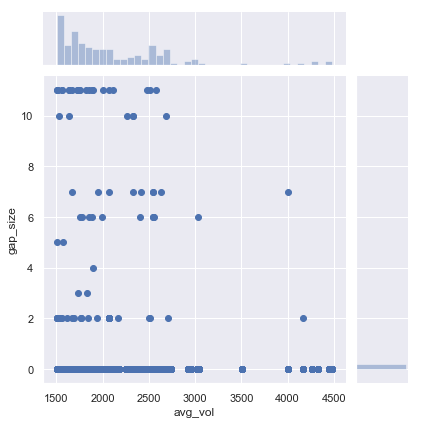

In [6]:
with con:   
    sql = pg.SQL('''
    WITH sel AS (
        SELECT intersection_uid, time_bin, avg_vol, gap_size 
        FROM miovision_api.volume_gap_1min
        WHERE avg_vol >= 1500
        )
    , percentage AS (
    SELECT gap_size, COUNT(*),
    ROUND(count(*)::numeric / 9221 * 100, 3) AS pct
    FROM sel
    GROUP BY gap_size
    ORDER BY gap_size
    )
    SELECT gap_size, pct,
    100 - ( sum(pct) over (order by gap_size asc rows between unbounded preceding and current row)) AS cumu_pct_desc
    FROM percentage
    ''')
    data_pct = pandasql.read_sql(sql, con)
    
print(data_pct)

with con:   
    sql = pg.SQL('''
    SELECT intersection_uid, time_bin, avg_vol, gap_size 
    FROM miovision_api.volume_gap_1min
    WHERE avg_vol >= 1500
    AND gap_size < 20
    ''')
    data_others = pandasql.read_sql(sql, con)

ax = sns.jointplot(x='avg_vol', y='gap_size', data=data_others)

# 3) **Option B**

We feel like the amount of data we are throwing away because of the gaps are a little too much? We are technically throwing away a full hour of data when there is a gap >= 2 minutes for intersection with high volume. (I personally find that the allowed gap size of 2 minutes is a little too smol?)

Therefore, I am trying to find out the results if the allowed gap size is modified. According to the results from above (Option A), I found the point/gap size where `cumu_pct_desc` is about 0.02. That means that for each volume category, we are only removing about 0.02% of the data.

Based on the table from option A, suggesting the following gaps: \
volume [0,99): 20 mins \
volume [100,499): 17 mins \
volume [500,1499): 14 mins \
volume [1500,∞): 8 mins

# 4) **Option C**

Am just curious to see what will the results look like if we use gap sizes that are less conservative than Option B and more lenient than Option A. Also wanted to try out gap sizes that are equally spaced.

Based on the table from option A, suggesting the following gaps: \
volume [0,99): 20 mins \
volume [100,499): 15 mins \
volume [500,1499): 10 mins \
volume [1500,∞): 5 mins

# 5) **Combined results** 

Putting together results from options A, B & C for easier comparison.

I was looking into the following details for all 3 options:

i) number of gaps exceeding allowed gap size 

ii) time of day distribution 

iii) proportion of data being removed 

With (iii) calculated using query below. Since this query takes quite some time to run, I put it into table first. So, I calculated the total volume & count of data in that hour as well as that of that day and find the percentage. I am only showing the average here for each intersection but you can find out more at `miovision_api.gaps_investigation`.
```sql
CREATE TABLE miovision_api.gaps_investigation AS
WITH dayy AS (
SELECT intersection_uid, DATE_TRUNC('day', datetime_bin) AS daily,  
	COUNT(*) AS daily_data_count, SUM(VOLUME) AS daily_sum_vol
FROM miovision_api.volumes
WHERE datetime_bin >= '2020-05-01'::timestamp without time zone
AND datetime_bin < '2020-07-01'::timestamp without time zone
GROUP BY intersection_uid, DATE_TRUNC('day', datetime_bin)
)
, hr AS (
SELECT intersection_uid, DATE_TRUNC('hour', datetime_bin) AS hourly,  
	COUNT(*) AS hr_data_count, SUM(VOLUME) AS hr_sum_vol
FROM miovision_api.volumes
WHERE datetime_bin >= '2020-05-01'::timestamp without time zone
AND datetime_bin < '2020-07-01'::timestamp without time zone
GROUP BY intersection_uid, DATE_TRUNC('hour', datetime_bin)
)
, outage AS (
SELECT intersection_uid, DATE_TRUNC('hour', gap_start) AS hourly
FROM miovision_api.unacceptable_gaps
)
SELECT outage.intersection_uid, hourly, hr_data_count, hr_sum_vol,
daily_data_count, daily_sum_vol,
ROUND(hr_data_count::numeric / daily_data_count::numeric * 100,3) AS count_pct,
ROUND(hr_sum_vol::numeric / daily_sum_vol::numeric * 100,3) AS vol_pct
FROM hr
INNER JOIN outage USING (intersection_uid, hourly)
INNER JOIN dayy ON dayy.intersection_uid = outage.intersection_uid AND dayy.daily = outage.hourly::date
```

## i) number of gaps exceeding allowed gap size

|allowed_gap A|count of gaps|allowed_gap B|count of gaps|allowed_gap C|count of gaps|
|-------------|-------------|-------------|-------------|-------------|-------------|
|2|131|8|50|5|86|
|5|133|14|7|10|41|
|10|80|17|16|15|21|
|20|8|20|8|20|8|
|TOTAL|352|TOTAL|81|TOTAL|156|

Trying to see what's the percentage of hours being 'thrown away' according to the total number of intersections and total number of days. Note that there are 8 cameras that got decommissioned on June 15th, one of which is already no longer functioning

|Month|# of days|hours per day|# of working intersections|days x int x hours|
|-----|---------|--------------|-------------------------|------------------|
|May|31|24|31|23064|
|June|14|24|7|2352|
|June|30|24|24|17280|
||||TOTAL:|42696|

|Options|# of gap-hours|total hours|percentage|
|-------|--------------|-----------|----------|
|Option A|352|42696|0.82%|
|Option B|81|42696|0.19%|
|Option C|156|42696|0.37%|

As you can see, we are only removing less than 1% of data for all 3 options above. We also looked at the number of gaps for each intersection and the result is shown below.

In [8]:
# number of gaps for each intersection
with con:   
    sql = pg.SQL('''
SELECT * FROM 
(SELECT intersection_uid, count(*) AS num_gaps_a
FROM miovision_api.unacceptable_gaps
GROUP BY intersection_uid
ORDER BY intersection_uid) a
LEFT JOIN 
(SELECT intersection_uid, count(*) AS num_gaps_b
FROM miovision_api.unacceptable_gaps_modified
GROUP BY intersection_uid
ORDER BY intersection_uid) b
USING (intersection_uid)
LEFT JOIN 
(SELECT intersection_uid, count(*) AS num_gaps_c
FROM miovision_api.unacceptable_gaps_modified2
GROUP BY intersection_uid
ORDER BY intersection_uid) c
USING (intersection_uid)
''')
    int_combined =  pandasql.read_sql(sql, con) 
    
print_table(sql,con)

intersection_uid,num_gaps_a,num_gaps_b,num_gaps_c
1,4,NaN,1.0
2,42,13.0,20.0
3,6,1.0,3.0
4,15,5.0,11.0
5,26,11.0,13.0
6,61,6.0,14.0
7,12,3.0,5.0
8,29,14.0,14.0
9,7,2.0,3.0
10,6,1.0,2.0


## ii) Time of day distribution

In [23]:
# ii) time of day distribution
with con:   
    sql = pg.SQL('''
SELECT * FROM 
(
SELECT EXTRACT(hour FROM gap_start) AS hour_of_day, count(*) AS occurrences_a, 
ROUND(count(*)::numeric / 352 * 100, 2) AS pct_a 
FROM miovision_api.unacceptable_gaps
WHERE gap_start < '2020-07-01'
GROUP BY EXTRACT(hour FROM gap_start)
ORDER BY EXTRACT(hour FROM gap_start)
) a
INNER JOIN 
(
SELECT EXTRACT(hour FROM gap_start) AS hour_of_day, count(*) AS occurrences_b, 
ROUND(count(*)::numeric / 81 * 100, 2) AS pct_b 
FROM miovision_api.unacceptable_gaps_modified
WHERE gap_start < '2020-07-01'
GROUP BY EXTRACT(hour FROM gap_start)
ORDER BY EXTRACT(hour FROM gap_start)
	) b USING (hour_of_day)
INNER JOIN
(
SELECT EXTRACT(hour FROM gap_start) AS hour_of_day, count(*) AS occurrences_c, 
ROUND(count(*)::numeric / 156 * 100, 2) AS pct_c 
FROM miovision_api.unacceptable_gaps_modified2
WHERE gap_start < '2020-07-01'
GROUP BY EXTRACT(hour FROM gap_start)
ORDER BY EXTRACT(hour FROM gap_start)
	) c USING (hour_of_day)
    ''')
    tod_combined =  pandasql.read_sql(sql, con)
    
print_table(sql,con)

hour_of_day,occurrences_a,pct_a,occurrences_b,pct_b,occurrences_c,pct_c
0.0,9,2.56,3,3.70,4,2.56
1.0,11,3.13,2,2.47,2,1.28
2.0,13,3.69,5,6.17,5,3.21
3.0,16,4.55,7,8.64,9,5.77
4.0,14,3.98,4,4.94,4,2.56
5.0,16,4.55,2,2.47,5,3.21
6.0,19,5.40,1,1.23,4,2.56
7.0,12,3.41,3,3.70,4,2.56
8.0,19,5.40,4,4.94,7,4.49
9.0,14,3.98,2,2.47,7,4.49


The table below shows time of day vs percentage with mean and standard deviation with the following query.

|Options|mean|std dev|
|-------|----|-------|
|Option A|4.169|1.321|
|Option B|4.165|1.988|
|Option C|4.168|1.582|

```sql
SELECT ROUND(avg(pct_a), 3) AS mean_a, ROUND(stddev(pct_a), 3) AS std_dev_a
	FROM (
SELECT EXTRACT(hour FROM gap_start) AS hour_of_day, count(*) AS occurrences_b, 
ROUND(count(*)::numeric / 81 * 100, 2) AS pct_b 
FROM miovision_api.unacceptable_gaps
WHERE gap_start < '2020-07-01'
GROUP BY EXTRACT(hour FROM gap_start)
ORDER BY EXTRACT(hour FROM gap_start)
	) a
```

Text(0.5, 1.0, 'Time of Day vs Occurrences')

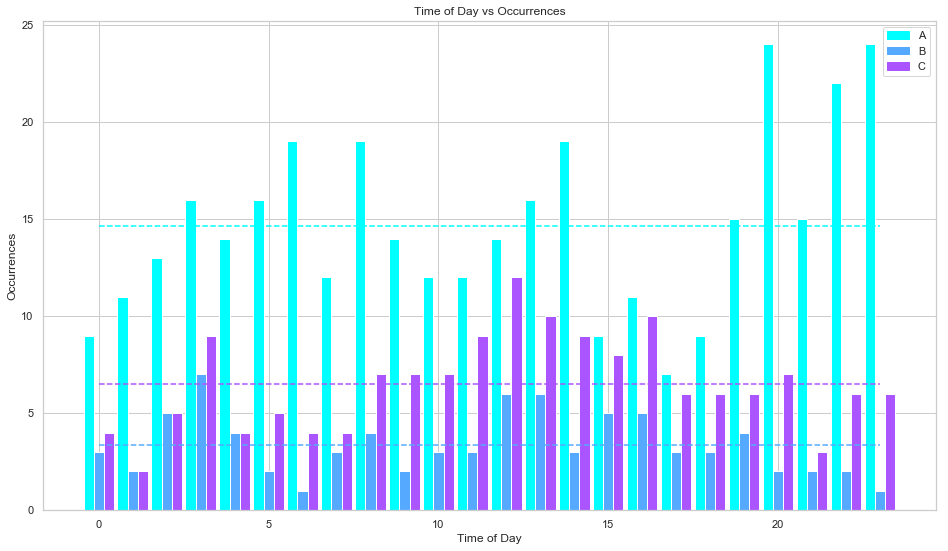

In [37]:
# time of day vs occurrences plot

fig, ax = plt.subplots (1,1, figsize=(16,9))
NUM_COLORS = 3
cm = plt.get_cmap('cool')
bar_width = 0.3
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

handles = []
ax.bar(tod_combined['hour_of_day'].values- bar_width, tod_combined['occurrences_a'], width=bar_width, color = colors[0], label="A")
handles.append(mpl.patches.Patch(color=colors[0], label= "A"))

ax.bar(tod_combined['hour_of_day'].values, tod_combined["occurrences_b"], width=bar_width, color = colors[1], label="B")
handles.append(mpl.patches.Patch(color=colors[1], label= "B"))

ax.bar(tod_combined['hour_of_day'].values + bar_width, tod_combined["occurrences_c"], width=bar_width, color = colors[2], label="C")
handles.append(mpl.patches.Patch(color=colors[2], label= "C"))

# Calculate the simple average of the data
# Got the below calculation from here: 
# https://stackoverflow.com/questions/12043672/how-to-take-draw-an-average-line-for-a-scatter-a-plot-in-matplotlib
mean_a = [np.mean( tod_combined['occurrences_a'])]*len(tod_combined['hour_of_day'])
mean_b = [np.mean( tod_combined['occurrences_b'])]*len(tod_combined['hour_of_day'])
mean_c = [np.mean( tod_combined['occurrences_c'])]*len(tod_combined['hour_of_day'])

# Plot the average line
mean_line_a = ax.plot(tod_combined['hour_of_day'],mean_a, label='Mean A', linestyle='--', color=colors[0])
mean_line_b = ax.plot(tod_combined['hour_of_day'],mean_b, label='Mean B', linestyle='--', color=colors[1])
mean_line_c = ax.plot(tod_combined['hour_of_day'],mean_c, label='Mean C', linestyle='--', color=colors[2])

ax.legend(handles=handles)
ax.set_xlabel('Time of Day')
ax.set_ylabel('Occurrences')
ax.set_title('Time of Day vs Occurrences')

Text(0.5, 1.0, 'Time of Day vs Percentage')

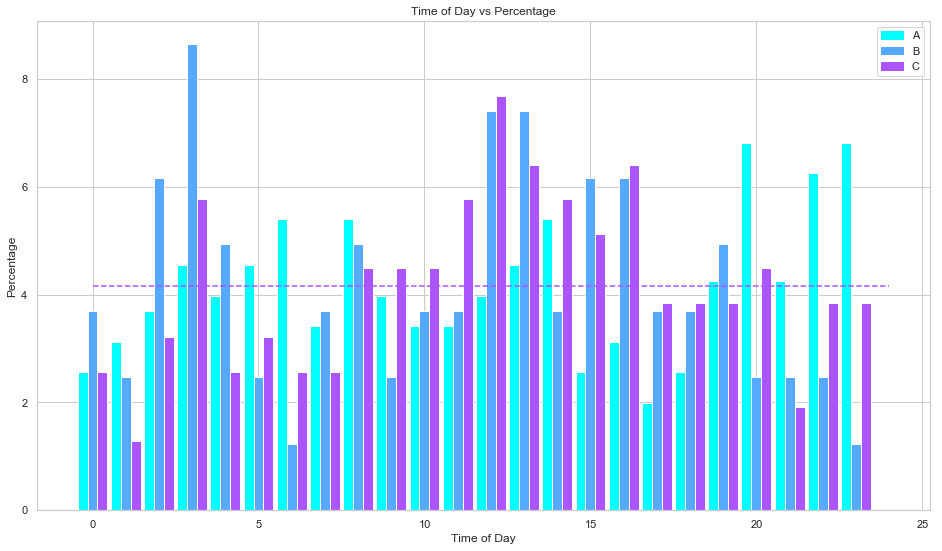

In [43]:
# time of day vs percentage plot

fig, ax = plt.subplots (1,1, figsize=(16,9))
NUM_COLORS = 3
cm = plt.get_cmap('cool')
bar_width = 0.3
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

handles = []
ax.bar(tod_combined['hour_of_day'].values- bar_width, tod_combined['pct_a'], width=bar_width, color = colors[0], label="A")
handles.append(mpl.patches.Patch(color=colors[0], label= "A"))

ax.bar(tod_combined['hour_of_day'].values, tod_combined["pct_b"], width=bar_width, color = colors[1], label="B")
handles.append(mpl.patches.Patch(color=colors[1], label= "B"))

ax.bar(tod_combined['hour_of_day'].values + bar_width, tod_combined["pct_c"], width=bar_width, color = colors[2], label="C")
handles.append(mpl.patches.Patch(color=colors[2], label= "C"))

ax.plot([0,24], [100/24, 100/24], label='Mean', linestyle='--', color=colors[2])

ax.legend(handles=handles)
ax.set_xlabel('Time of Day')
ax.set_ylabel('Percentage')
ax.set_title('Time of Day vs Percentage')

## iii) Proportion of data 

In [10]:
# WIP change x-axis to day instead of intersection_uid

# iii) proportion of data being removed
# NOTE that not all intersections have gaps. 
# Intersections without unacceptable gaps are 1,32

with con:   
    sql = pg.SQL('''
SELECT * FROM 
(
SELECT intersection_uid, ROUND(AVG(count_pct), 3) AS avg_count_pct_a, 
ROUND(AVG(vol_pct), 3) AS avg_vol_pct_a
FROM miovision_api.gaps_investigation
GROUP BY intersection_uid
ORDER BY intersection_uid
) a
LEFT JOIN 
(
SELECT intersection_uid, ROUND(AVG(count_pct), 3) AS avg_count_pct_b, 
ROUND(AVG(vol_pct), 3) AS avg_vol_pct_b
FROM miovision_api.gaps_investigation_modified
GROUP BY intersection_uid
ORDER BY intersection_uid
	) b USING (intersection_uid)
LEFT JOIN
(
SELECT intersection_uid, ROUND(AVG(count_pct), 3) AS avg_count_pct_c, 
ROUND(AVG(vol_pct), 3) AS avg_vol_pct_c
FROM miovision_api.gaps_investigation_modified2
GROUP BY intersection_uid
ORDER BY intersection_uid
	) c USING (intersection_uid)
    ''')
    pro_combined =  pandasql.read_sql(sql, con) 
    
print_table(sql,con)

intersection_uid,avg_count_pct_a,avg_vol_pct_a,avg_count_pct_b,avg_vol_pct_b,avg_count_pct_c,avg_vol_pct_c
1,5.482,5.420,NaN,NaN,NaN,NaN
2,2.986,2.734,4.571,4.489,3.782,3.573
3,4.028,3.296,NaN,NaN,4.662,4.109
4,3.376,3.440,4.444,4.894,4.053,4.320
5,1.338,1.243,0.898,0.965,0.920,0.938
6,2.415,2.424,2.406,2.249,2.760,2.612
7,2.921,2.846,0.289,0.182,3.681,3.394
8,1.444,1.309,0.580,0.561,0.580,0.561
9,3.624,3.853,4.272,4.755,4.951,5.520
10,4.768,5.051,NaN,NaN,5.175,5.960


Text(0.5, 1.0, 'Intersection vs Average Volume Percentage')

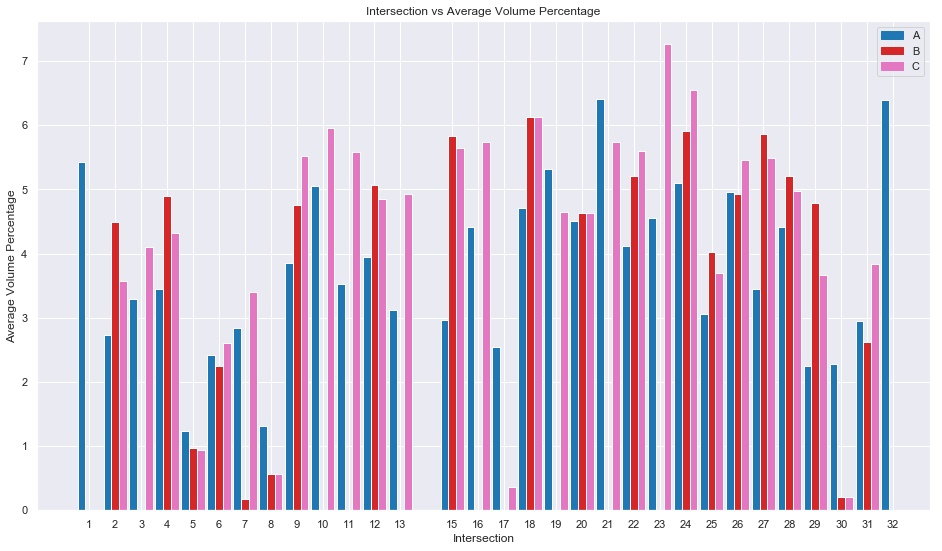

In [11]:
fig, ax = plt.subplots (1,1, figsize=(16,9))
NUM_COLORS = 3
cm = plt.get_cmap('tab10')
bar_width = 0.3
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

handles = []
ax.bar(pro_combined['intersection_uid'].values- bar_width, pro_combined['avg_vol_pct_a'], width=bar_width, color = colors[0], label="A")
handles.append(mpl.patches.Patch(color=colors[0], label= "A"))

ax.bar(pro_combined['intersection_uid'].values, pro_combined["avg_vol_pct_b"], width=bar_width, color = colors[1], label="B")
handles.append(mpl.patches.Patch(color=colors[1], label= "B"))

ax.bar(pro_combined['intersection_uid'].values + bar_width, pro_combined["avg_vol_pct_c"], width=bar_width, color = colors[2], label="C")
handles.append(mpl.patches.Patch(color=colors[2], label= "C"))

ax.set_xticks(pro_combined['intersection_uid'])

ax.legend(handles=handles, loc=1)
ax.set_xlabel('Intersection')
ax.set_ylabel('Average Volume Percentage')
ax.set_title('Intersection vs Average Volume Percentage')

# Conclusion

We have decided to move on with Option C because Option A seems a little too strict and Option B seems a little too conservative? However, we can always come back and change it in the future. Our concern is that we are removing too much of data and we may be biasing our resulting data.